<a href="https://colab.research.google.com/github/JozefSL/pyNotes/blob/main/pymc3/pymc42withSigma_WSLm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
from datetime import datetime
from dateutil.relativedelta import relativedelta
from google.colab import drive
import os
import sqlite3
import pymc as pm
import seaborn as sns
import statsmodels.formula.api as smf
from matplotlib import rcParams
import numpy as np
import arviz as az
import matplotlib.pyplot as plt
import aesara

In [2]:
#import w
# %load_ext watermark
%pip install watermark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.6 MB 6.5 MB/s 


In [3]:
%load_ext watermark

In [4]:
%watermark --iversions

aesara     : 2.7.9
google     : 2.0.3
seaborn    : 0.11.2
pymc       : 4.1.4
statsmodels: 0.12.2
sqlite3    : 2.6.0
arviz      : 0.12.1
numpy      : 1.21.6
matplotlib : 3.2.2
pandas     : 1.3.5



In [5]:
from google.colab import files
uploaded = files.upload()

Saving gridData4Hiro_EFandPerm.xlsx to gridData4Hiro_EFandPerm.xlsx


In [308]:
data = pd.read_excel('gridData4Hiro_EFandPerm.xlsx', sheet_name='Permian__42')

In [309]:
data.tail()

,API15,feDate,drill_type,WaterGal,SandLB,LL,maxPo,maxPg,M6o,M6g,MHB,BasinID
37069,142109326220000,2014-01-01,H,1790152.0,3020106.0,4521.0,409.0,2676.0,43108.0,303318.0,DM71vx,42.0
37070,142301320320000,2014-01-01,H,8538222.0,9230820.0,6734.0,1078.0,4243.0,103456.0,458150.0,DM81dx,42.0
37071,142301319920000,2014-01-01,H,2691036.0,3291677.0,3812.0,316.0,1363.0,42451.0,161517.0,DM81fq,42.0
37072,142329388850000,2014-01-01,V,1035692.0,NaN,NaN,20.0,75.0,2559.0,11531.0,DM91bv,42.0
37073,142317390120000,2014-01-01,V,2103152.0,1323802.0,NaN,26.0,20.0,3244.0,2293.0,DM92cl,42.0


In [310]:
data.drop(data[data.drill_type == 'V'].index, inplace=True)
data.drop(data[data.drill_type == 'D'].index, inplace=True)
data.drop(data[data.LL < 1].index, inplace=True)
data.drop(data[data.maxPo < 1].index, inplace=True)
data.drop(data[data.maxPg < 1].index, inplace=True)
data.drop(data[data.WaterGal < 1].index, inplace=True)
data.drop(data[data.WaterGal > 1.0e+08].index, inplace=True)
data.drop(data[data.SandLB < 1].index, inplace=True)
data.drop(data[data.SandLB > 1.0e+08].index, inplace=True)
data.drop(data[data.feDate < '2017-01-01'].index, inplace=True)
data.dropna(inplace=True)


In [311]:
data = data.sort_values(['API15','feDate'], ascending=True)
data.drop_duplicates('API15',keep='last',inplace=True)
data.reset_index(inplace=True, drop=True)
data.tail()

,API15,feDate,drill_type,WaterGal,SandLB,LL,maxPo,maxPg,M6o,M6g,MHB,BasinID
19007,142501373120000,2021-10-14,H,2239230.0,2880087.0,5066.0,424.0,288.0,46771.0,35963.0,DM83ld,42.0
19008,142501373180000,2021-10-01,H,3460124.0,3412983.0,5127.0,555.0,218.0,45773.0,20223.0,DM83lf,42.0
19009,142501373190000,2021-11-04,H,5463654.0,5220354.0,7684.0,537.0,349.0,39750.0,27900.0,DM83mb,42.0
19010,142501373260000,2021-11-15,H,4816980.0,5218256.0,7684.0,576.0,286.0,38000.0,19593.0,DM83mb,42.0
19011,142501373390000,2021-10-24,H,3892855.0,4206180.0,4973.0,330.0,143.0,34095.0,19534.0,DM83lf,42.0


In [312]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19012 entries, 0 to 19011
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   API15       19012 non-null  int64         
 1   feDate      19012 non-null  datetime64[ns]
 2   drill_type  19012 non-null  object        
 3   WaterGal    19012 non-null  float64       
 4   SandLB      19012 non-null  float64       
 5   LL          19012 non-null  float64       
 6   maxPo       19012 non-null  float64       
 7   maxPg       19012 non-null  float64       
 8   M6o         19012 non-null  float64       
 9   M6g         19012 non-null  float64       
 10  MHB         19012 non-null  object        
 11  BasinID     19012 non-null  float64       
dtypes: datetime64[ns](1), float64(8), int64(1), object(2)
memory usage: 1.7+ MB


In [313]:
data['YY'] = data['feDate'].dt.year

In [315]:
Y_data = data.YY.unique()
Y_count = len(data.YY.unique())

In [316]:
M_names = data.MHB.unique()
M_count = len(data.MHB.unique())

M_names = pd.DataFrame(M_names, columns=['MHB'])
M_names = M_names.reset_index()
M_names.rename(columns={'index' : 'MHBn'}, inplace=True)

In [317]:
M_names.head()

,MHBn,MHB
0,0,DM73xa
1,1,DM72wx
2,2,DM72xx
3,3,DM83aa
4,4,DM72qk


In [318]:
data = data.merge(M_names, on=['MHB'], how='left')

In [169]:
#data = data.set_index('API15')

In [319]:
data.tail()

,API15,feDate,drill_type,WaterGal,SandLB,LL,maxPo,maxPg,M6o,M6g,MHB,BasinID,YY,MHBn
19007,142501373120000,2021-10-14,H,2239230.0,2880087.0,5066.0,424.0,288.0,46771.0,35963.0,DM83ld,42.0,2021,174
19008,142501373180000,2021-10-01,H,3460124.0,3412983.0,5127.0,555.0,218.0,45773.0,20223.0,DM83lf,42.0,2021,1031
19009,142501373190000,2021-11-04,H,5463654.0,5220354.0,7684.0,537.0,349.0,39750.0,27900.0,DM83mb,42.0,2021,1019
19010,142501373260000,2021-11-15,H,4816980.0,5218256.0,7684.0,576.0,286.0,38000.0,19593.0,DM83mb,42.0,2021,1019
19011,142501373390000,2021-10-24,H,3892855.0,4206180.0,4973.0,330.0,143.0,34095.0,19534.0,DM83lf,42.0,2021,1031


In [322]:
data1 = data[['API15','maxPg', 'maxPo', 'LL', 'WaterGal', 'SandLB']].copy()
data1['WSL'] = (data1['WaterGal'] +data['SandLB'])/data['LL']

data1.tail(3)

,API15,maxPg,maxPo,LL,WaterGal,SandLB,WSL
19009,142501373190000,349.0,537.0,7684.0,5463654.0,5220354.0,1390.422697
19010,142501373260000,286.0,576.0,7684.0,4816980.0,5218256.0,1305.991150
19011,142501373390000,143.0,330.0,4973.0,3892855.0,4206180.0,1628.601448


In [323]:
data1 = data1.set_index('API15')
sData = (data1-data1.mean())/(2*data1.std()).copy()


In [324]:
sData.describe().round(3)

,maxPg,maxPo,LL,WaterGal,SandLB,WSL
count,19012.000,19012.000,19012.000,19012.000,19012.000,19012.000
mean,-0.000,-0.000,-0.000,0.000,0.000,-0.000
std,0.500,0.500,0.500,0.500,0.500,0.500
min,-0.495,-0.881,-1.688,-1.235,-1.180,-1.153
25%,-0.311,-0.326,-0.288,-0.355,-0.316,-0.162
50%,-0.192,-0.072,0.200,0.027,-0.022,-0.022
75%,0.134,0.234,0.328,0.329,0.268,0.143
max,5.311,5.136,2.553,3.427,5.189,28.095


In [325]:
sData.reset_index(inplace=True)

In [327]:
sData.tail(3)

,API15,maxPg,maxPo,LL,WaterGal,SandLB,WSL
19009,142501373190000,-0.409207,-0.358356,-0.180435,-0.836030,-0.837903,-0.765441
19010,142501373260000,-0.424704,-0.320293,-0.180435,-0.883207,-0.838040,-0.789012
19011,142501373390000,-0.459881,-0.560383,-0.739842,-0.950624,-0.904313,-0.698947


In [332]:
wd = pd.merge(sData, data[['API15','MHBn','YY']], how='inner', left_on='API15', right_on='API15') #.drop_duplicates()
#wd = pd.merge(sData, data[['API15','MHBn']], how='outer', left_index=True, right_index=True).drop_duplicates()

In [333]:
wd.tail()

,API15,maxPg,maxPo,LL,WaterGal,SandLB,WSL,MHBn,YY
19007,142501373120000,-0.424212,-0.468641,-0.720652,-1.071261,-0.991148,-0.871501,174,2021
19008,142501373180000,-0.441432,-0.340789,-0.708065,-0.982193,-0.956253,-0.779359,1031,2021
19009,142501373190000,-0.409207,-0.358356,-0.180435,-0.836030,-0.837903,-0.765441,1019,2021
19010,142501373260000,-0.424704,-0.320293,-0.180435,-0.883207,-0.838040,-0.789012,1019,2021
19011,142501373390000,-0.459881,-0.560383,-0.739842,-0.950624,-0.904313,-0.698947,1031,2021


In [334]:
MHB_idx = wd.MHBn.values
YY_idx = wd.YY.values

In [335]:
avgWSL = wd[['WSL','MHBn']].groupby(['MHBn'],as_index=False).mean()
avgWSL.columns = ['MHBn', 'WSLm']

In [336]:
avgWSL.tail()

,MHBn,WSLm
1039,1039,-0.917159
1040,1040,-1.066278
1041,1041,-0.913059
1042,1042,2.534850
1043,1043,-0.733533


In [337]:
M_names = M_names.merge(avgWSL, left_on='MHBn', right_on='MHBn')


In [338]:
M_names.tail()

,MHBn,MHB,WSLm
1039,1039,DM83li,-0.917159
1040,1040,DM83oa,-1.066278
1041,1041,DM83la,-0.913059
1042,1042,DM82ox,2.534850
1043,1043,DM83ne,-0.733533


In [340]:
wd = wd.merge(M_names[['MHBn','WSLm']], how='inner', left_on='MHBn', right_on='MHBn')

In [343]:
wd.tail(3)

,API15,maxPg,maxPo,LL,WaterGal,SandLB,WSL,MHBn,YY,WSLm
19009,142501370990000,-0.487432,-0.770217,-0.439401,-1.183849,4.227041,2.462151,1042,2019,2.534850
19010,142501371000000,-0.484972,-0.474497,-0.299704,-1.178065,5.038344,2.607549,1042,2019,2.534850
19011,142501371050000,-0.479315,-0.782904,-0.723954,-0.896455,-0.985690,-0.733533,1043,2019,-0.733533


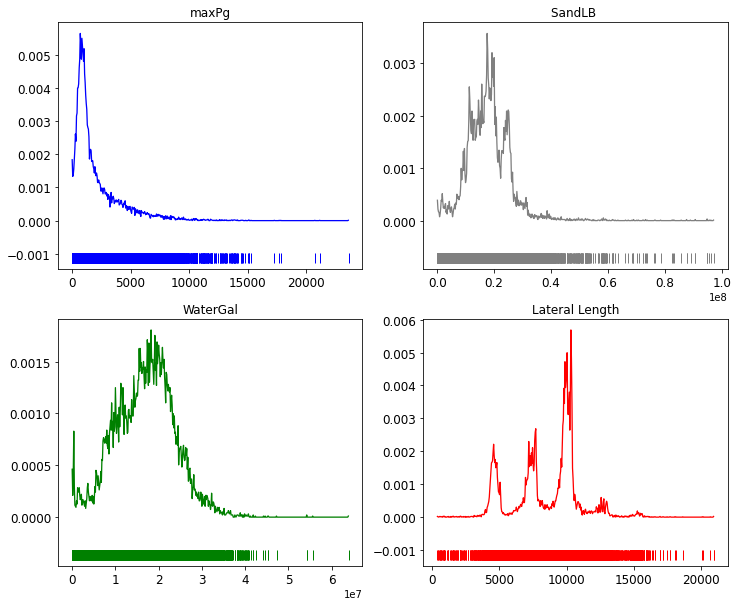

In [342]:
fig = plt.figure(figsize = (12,10))

ax1 = fig.add_subplot(2, 2, 1)
ax1.set_title('maxPg')
az.plot_kde(data['maxPg'],textsize=12, plot_kwargs={'color': 'b'}, rug=True, bw=2)

ax2 = fig.add_subplot(2, 2, 2)
ax2.set_title('SandLB ')
az.plot_kde(data['SandLB'],textsize=12, plot_kwargs={'color': 'gray'}, rug=True, bw=2)

ax3 = fig.add_subplot(2, 2, 3)
ax3.set_title('WaterGal')
az.plot_kde(data['WaterGal'],textsize=12, plot_kwargs={'color': 'green'}, rug=True, bw=2)

ax4 = fig.add_subplot(2, 2, 4)
ax4.set_title('Lateral Length')
az.plot_kde(data['LL'],textsize=12, plot_kwargs={'color': 'red'}, rug=True, bw=2);

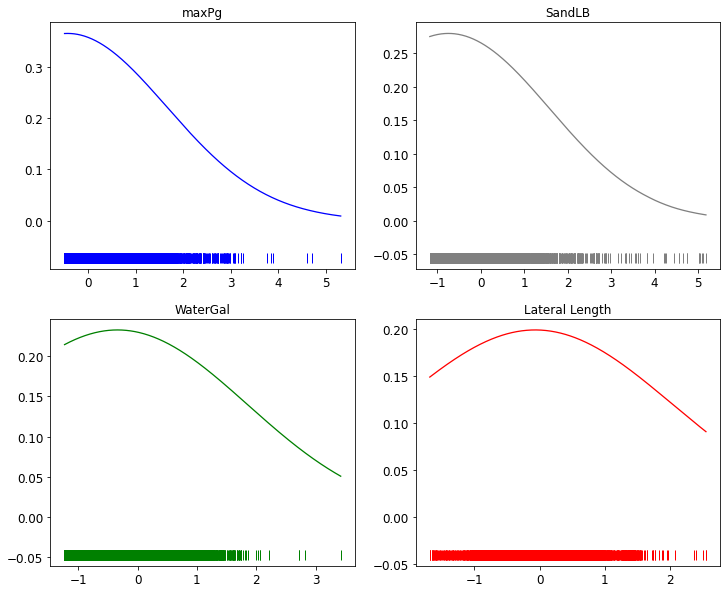

In [344]:
fig = plt.figure(figsize = (12,10))

ax1 = fig.add_subplot(2, 2, 1)
ax1.set_title('maxPg')
az.plot_kde(sData['maxPg'],textsize=12, plot_kwargs={'color': 'b'}, rug=True, bw=2)

ax2 = fig.add_subplot(2, 2, 2)
ax2.set_title('SandLB')
az.plot_kde(sData['SandLB'],textsize=12, plot_kwargs={'color': 'gray'}, rug=True, bw=2)

ax3 = fig.add_subplot(2, 2, 3)
ax3.set_title('WaterGal')
az.plot_kde(sData['WaterGal'],textsize=12, plot_kwargs={'color': 'green'}, rug=True, bw=2)

ax4 = fig.add_subplot(2, 2, 4)
ax4.set_title('Lateral Length')
az.plot_kde(sData['LL'],textsize=12, plot_kwargs={'color': 'red'}, rug=True, bw=2);

In [188]:
ls_1 = smf.ols('maxPg ~ WaterGal + SandLB + LL ', data=sData).fit()
ls_1.summary(alpha=0.11)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  maxPg   R-squared:                       0.025
Model:                            OLS   Adj. R-squared:                  0.024
Method:                 Least Squares   F-statistic:                     162.6
Date:                Wed, 02 Nov 2022   Prob (F-statistic):          4.22e-104
Time:                        15:08:44   Log-Likelihood:                -13821.
No. Observations:               19376   AIC:                         2.765e+04
Df Residuals:                   19372   BIC:                         2.768e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.055      0.945]
------------------------------------------------------------------------------
Intercept   3.123e-17      0.004    8.8e-15      1.000      -0.006       0.006
WaterGal      -0.0126      0.011     -1.187      0.235      -0.030       0.004
SandLB         0.1978      0.010     20.748      0.000       0.183       0.213
LL            -0.1109      0.010    -10.931      0.000      -0.127      -0.095
==============================================================================
Omnibus:                     9338.269   Durbin-Watson:                   1.614
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            60997.287
Skew:                           2.252   Prob(JB):                         0.00
Kurtosis:                      10.434   Cond. No.                         3.62
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [189]:
wd.tail()

,maxPg,maxPo,LL,WaterGal,SandLB,WSL,MHBn,WSLm
API15,,,,,,,,
142501370990000,-0.488061,-0.768094,-0.434277,-1.170196,4.165356,2.403570,730,2.474536
142501371000000,-0.485594,-0.472469,-0.295200,-1.164452,4.964603,2.545501,730,2.474536
142501371050000,-0.479918,-0.780777,-0.717565,-0.884799,-0.969913,-0.715908,797,-0.774578
142501371050000,-0.479918,-0.780777,-0.717565,-0.963566,-0.968530,-0.773424,797,-0.774578
142501371050000,-0.479918,-0.780777,-0.717565,-1.053202,-0.961610,-0.834404,797,-0.774578


In [117]:
with pm.Model() as model_vi1:
# Priors
    μ_α = pm.Normal('μ_α', mu=0, sigma=0.5)
    σ_α = pm.Normal('σ_α', mu=0, sigma=0.5)
    # Random intercepts
    α = pm.Normal('α', mu=μ_α, sigma=σ_α, shape=M_count)
    # Common slope
    βw = pm.Normal('βw', mu=0, sigma=0.5)
    βs = pm.Normal('βs', mu=0, sigma=0.5)
    βh = pm.Normal('βh', mu=0, sigma=0.5)
   
    # Model error
    ϵ = pm.Normal('ϵ', mu=0, sigma=0.5)

    μ = α[MHB_idx] + βw*wd.WaterGal + βs*wd.SandLB + βh*wd.LL
    # Data likelihood
    maxPg = pm.Normal('maxPg', μ, ϵ, observed=wd.maxPg)

    trace_vi1 = pm.sample(2000, tune=1000, cores=2)

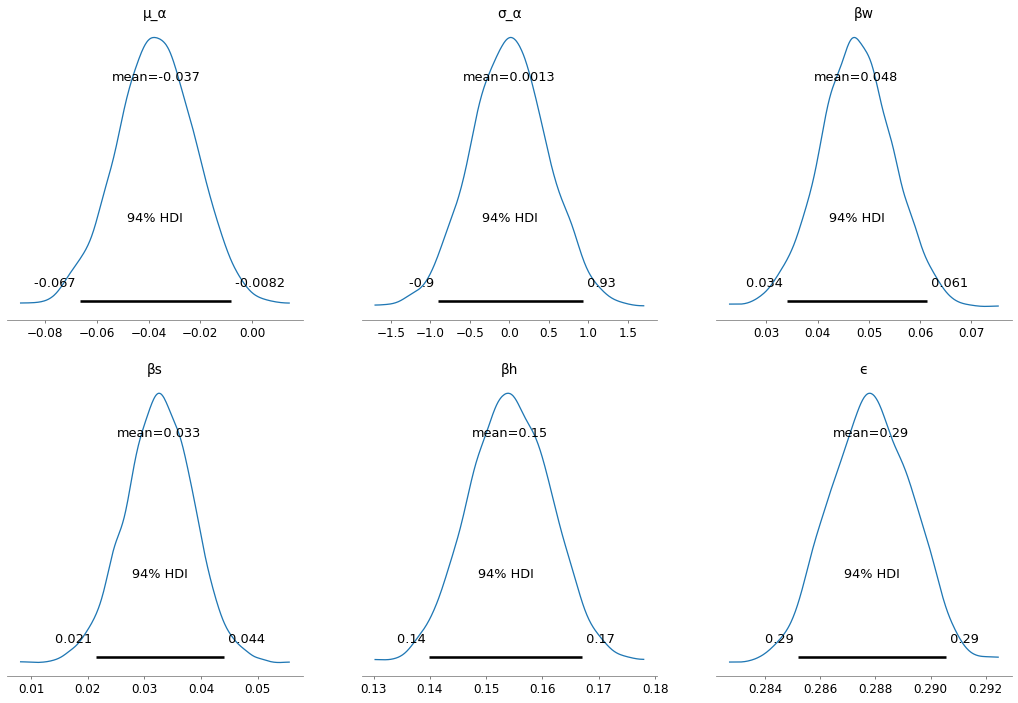

In [118]:
pm.plot_posterior(trace_vi1, var_names=['μ_α', 'σ_α', 'βw', 'βs', 'βh', 'ϵ'],
                  figsize=(18,12), textsize=12);

In [119]:
pm.summary(trace_vi1).round(2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
μ_α,-0.04,0.02,-0.07,-0.01,0.0,0.00,8643.0,2777.0,1.0
σ_α,0.00,0.49,-0.90,0.93,0.0,0.01,9147.0,2229.0,1.0
α[0],-0.32,0.05,-0.41,-0.22,0.0,0.00,8772.0,2555.0,1.0
α[1],-0.29,0.03,-0.35,-0.22,0.0,0.00,9930.0,2444.0,1.0
α[2],1.26,0.04,1.18,1.34,0.0,0.00,8315.0,2594.0,1.0
...,...,...,...,...,...,...,...,...,...
α[1043],-0.22,0.25,-0.70,0.24,0.0,0.00,7373.0,2451.0,1.0
βw,0.05,0.01,0.03,0.06,0.0,0.00,4496.0,3259.0,1.0
βs,0.03,0.01,0.02,0.04,0.0,0.00,5419.0,3250.0,1.0
βh,0.15,0.01,0.14,0.17,0.0,0.00,4900.0,3262.0,1.0


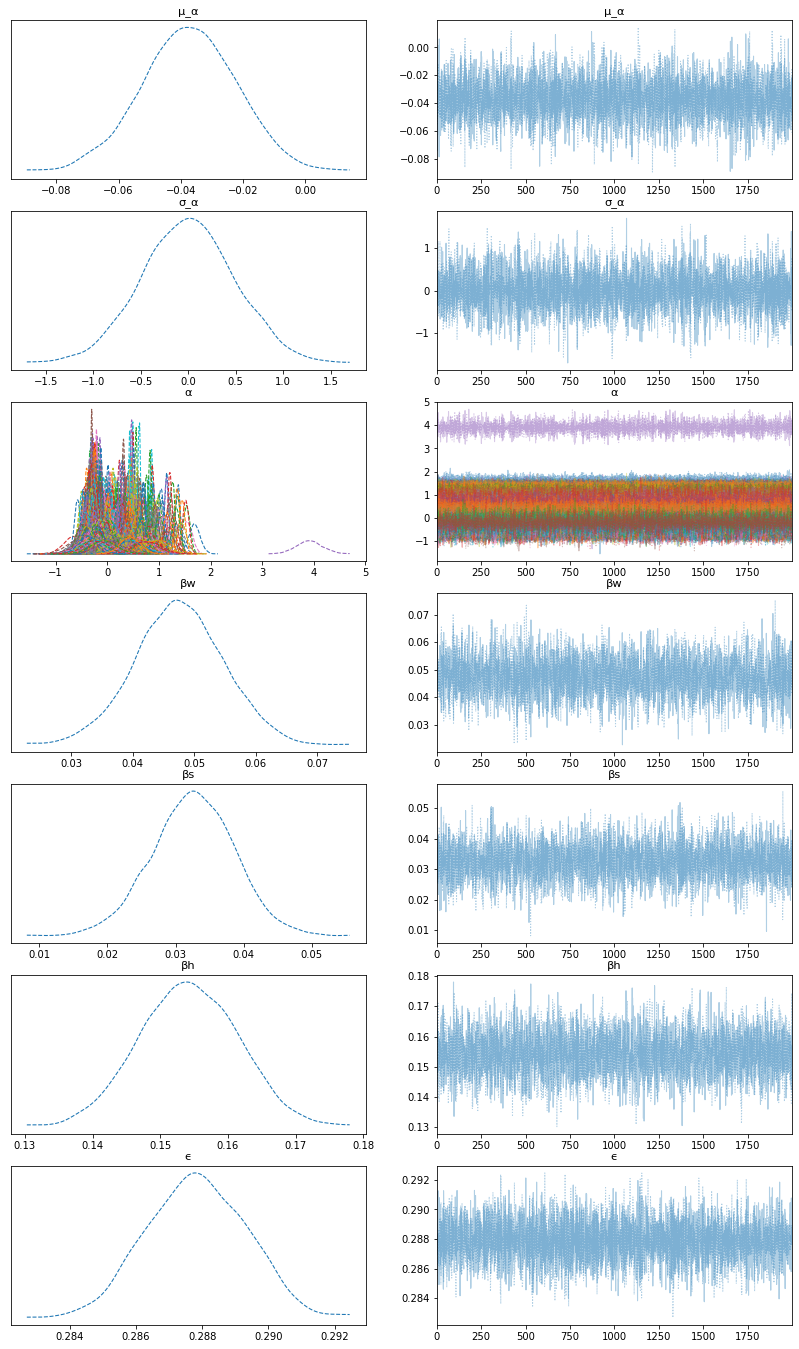

In [120]:
pm.plot_trace(trace_vi1, compact=True, combined=True, figsize=(14,24));


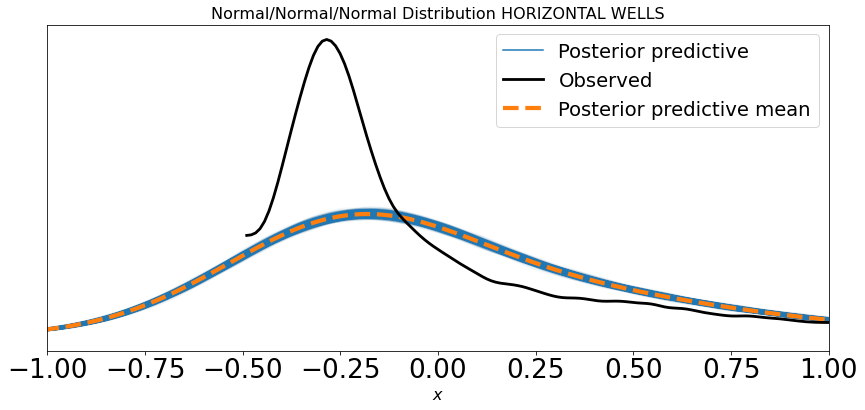

In [121]:
ppc1 = pm.sample_posterior_predictive(trace=trace_vi1, model=model_vi1)
az.plot_ppc(ppc1, alpha=0.03, figsize=(14, 6)) #, backend="bokeh")
plt.xlim(-1, 1)
plt.title("μ = α[MHB_idx] + βw*wd.WaterGal + βs*wd.SandLB + βh*wd.LL", fontsize=16)
plt.xlabel('$x$', fontsize=16);

In [265]:
with pm.Model() as modelHiro_v1:
# Priors
    μ_α = pm.Normal('μ_α', mu=0, sigma=0.5)
    σ_α = pm.HalfNormal('σ_α', sigma=0.5)
    # Random intercepts
    α = pm.Normal('α', mu=μ_α, sigma=0.5, shape=M_count)
    # Common slope
    #βw = pm.Normal('βw', mu=20, sigma=100)
    #βs = pm.Normal('βs', mu=-0.25, sigma=100)
    β = pm.Normal('β', mu=0, sigma=0.5, shape=M_count)
   
    # Model error
    ϵ = pm.Normal('ϵ', mu=0, sigma=0.5)

    μ = α[MHB_idx] + β[MHB_idx]*wd.LL
    # Data likelihood
    maxPg = pm.Normal('maxPg', μ, ϵ, observed=wd.maxPg)

    traceHiro_v1 = pm.sample(2000, tune=1000, cores=2)

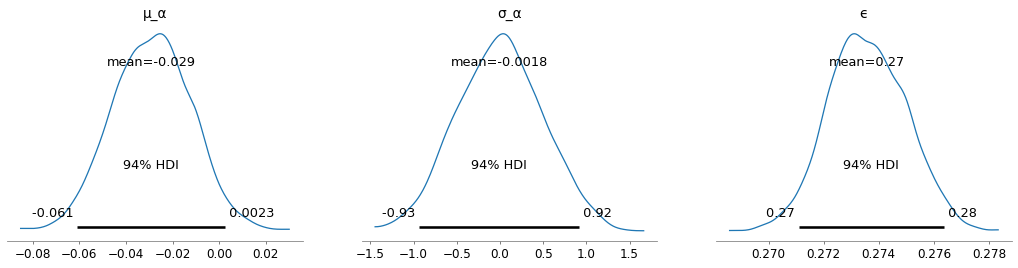

In [123]:
pm.plot_posterior(traceHiro_v1, var_names=['μ_α', 'σ_α', 'ϵ'],
                  figsize=(18,4), textsize=12);

In [124]:
pm.summary(traceHiro_v1).round(2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
μ_α,-0.03,0.02,-0.06,0.00,0.0,0.00,7025.0,2945.0,1.0
σ_α,-0.00,0.50,-0.93,0.92,0.0,0.01,10172.0,2771.0,1.0
α[0],-0.30,0.05,-0.40,-0.20,0.0,0.00,9313.0,3035.0,1.0
α[1],-0.25,0.06,-0.36,-0.15,0.0,0.00,8968.0,2798.0,1.0
α[2],1.26,0.04,1.18,1.33,0.0,0.00,9145.0,2495.0,1.0
...,...,...,...,...,...,...,...,...,...
β[1040],-0.04,0.23,-0.50,0.38,0.0,0.00,7979.0,2624.0,1.0
β[1041],-0.15,0.38,-0.85,0.54,0.0,0.01,9327.0,3099.0,1.0
β[1042],0.08,0.41,-0.68,0.87,0.0,0.01,7082.0,3024.0,1.0
β[1043],0.19,0.43,-0.62,0.98,0.0,0.01,9098.0,3021.0,1.0


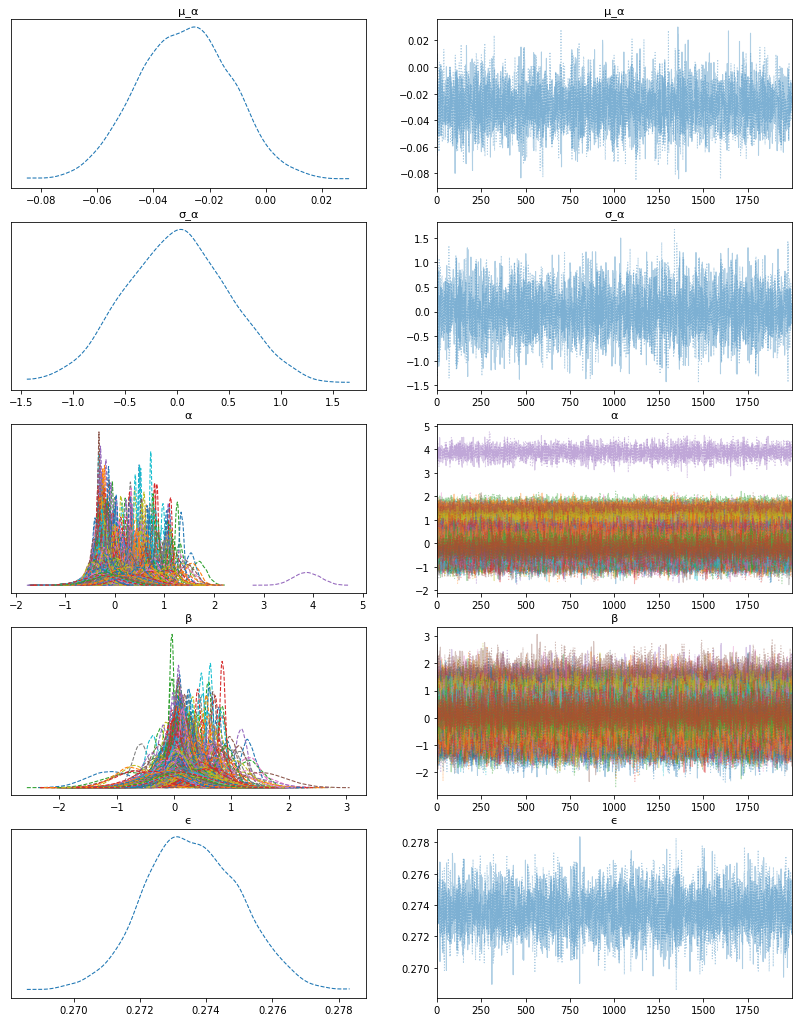

In [125]:
pm.plot_trace(traceHiro_v1, compact=True, combined=True, figsize=(14,18));

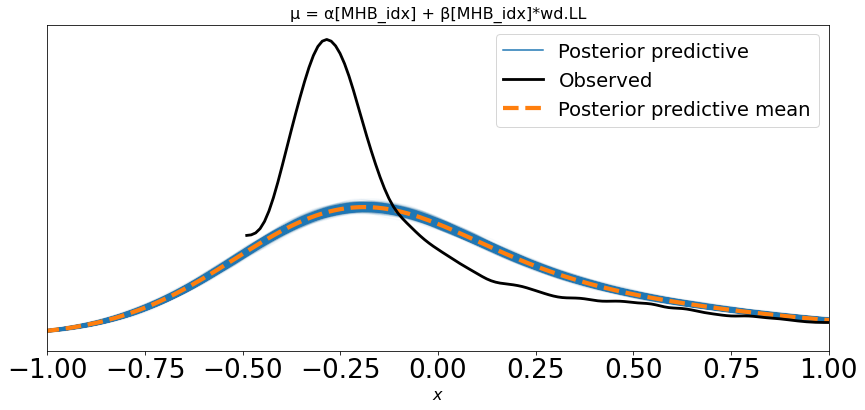

In [266]:
ppcH1 = pm.sample_posterior_predictive(trace=traceHiro_v1, model=modelHiro_v1)
az.plot_ppc(ppcH1, alpha=0.03, figsize=(14, 6)) #, backend="bokeh")
plt.xlim(-1, 1)
plt.title("μ = α[MHB_idx] + β[MHB_idx]*wd.LL", fontsize=16)
plt.xlabel('$x$', fontsize=16);

In [198]:
with pm.Model() as modelHiro_v2:
# Priors
    μ_α = pm.Normal('μ_α', mu=0, sigma=0.5)
    σ_α = pm.HalfNormal('σ_α', sigma=0.5)
    α = pm.Normal('α', mu=μ_α, sigma=σ_α, shape=M_count)
    
    μ_β = pm.Normal('μ_β', mu=0, sigma=0.5)
    σ_β = pm.HalfNormal('σ_β', sigma=0.5)    
    β = pm.Normal('β', mu=μ_β, sigma=σ_β, shape=M_count)
    
    #γ = pm.Normal('γ', mu=0, sigma=0.5)

# Model error
    ϵ = pm.Normal('ϵ', mu=0, sigma=0.5)

    μ = α[MHB_idx] + β[MHB_idx]*wd.WSLm*wd.LL
# Data likelihood
    maxPg = pm.Normal('maxPg', μ, ϵ, observed=wd.maxPg)

    traceHiro_v2 = pm.sample(2000, tune=1000, cores=2)

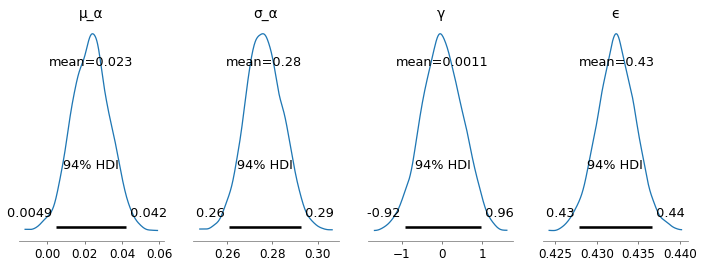

In [191]:
pm.plot_posterior(traceHiro_v2, var_names=['μ_α', 'σ_α', 'γ', 'ϵ'],
                  figsize=(12,4), textsize=12);

In [192]:
pm.summary(traceHiro_v2).round(2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
μ_α,0.02,0.01,0.00,0.04,0.00,0.00,2807.0,2606.0,1.0
σ_α,0.28,0.01,0.26,0.29,0.00,0.00,1369.0,2189.0,1.0
α[0],0.21,0.08,0.07,0.35,0.00,0.00,3306.0,2342.0,1.0
α[1],-0.20,0.05,-0.30,-0.11,0.00,0.00,4435.0,2593.0,1.0
α[2],0.26,0.06,0.15,0.38,0.00,0.00,4482.0,2957.0,1.0
...,...,...,...,...,...,...,...,...,...
β[1041],-0.12,0.48,-1.02,0.77,0.01,0.01,4329.0,2070.0,1.0
β[1042],-0.12,0.47,-1.01,0.76,0.01,0.01,3859.0,2659.0,1.0
β[1043],-0.11,0.47,-1.02,0.76,0.01,0.01,4047.0,2185.0,1.0
γ,0.00,0.50,-0.92,0.96,0.01,0.01,4933.0,2441.0,1.0


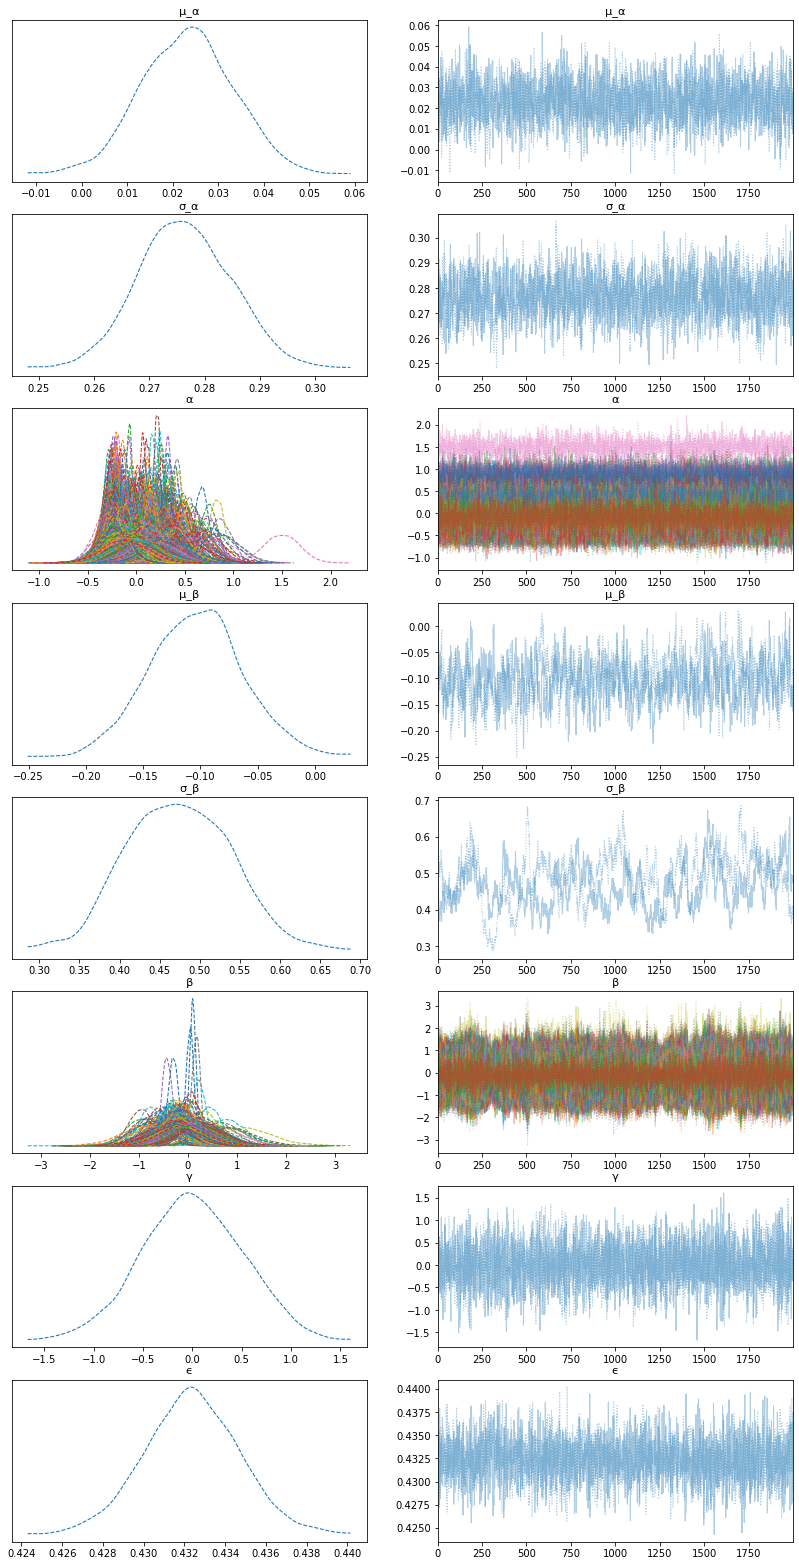

In [193]:
pm.plot_trace(traceHiro_v2, compact=True, combined=True, figsize=(14,28));

In [160]:
#ppcH2test = pm.sample_posterior_predictive(trace=traceHiro_v2, var_names=["maxPg"], model=modelHiro_v2)
#ppc = pm.sample_posterior_predictive(trace_1, var_names=["a", "b", "obs"], random_seed=RANDOM_SEED

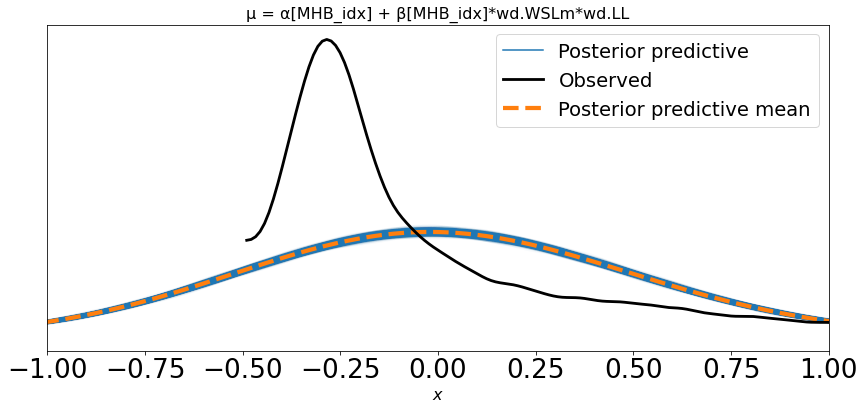

In [194]:
ppcH2 = pm.sample_posterior_predictive(trace=traceHiro_v2, model=modelHiro_v2)
az.plot_ppc(ppcH2, alpha=0.03, figsize=(14, 6)) #, backend="bokeh")
plt.xlim(-1, 1)
plt.title("μ = α[MHB_idx] + β[MHB_idx]*wd.WSLm*wd.LL", fontsize=16)
plt.xlabel('$x$', fontsize=16);

In [267]:
with pm.Model() as model_avg:
# Priors
    μ_α = pm.Normal('μ_α', mu=0, sigma=0.5)
    σ_α = pm.HalfNormal('σ_α', sigma=0.5)
    # Random intercepts
    α = pm.Normal('α', mu=μ_α, sigma=σ_α, shape=M_count)
    # Common slope
    #βw = pm.Normal('βw', mu=20, sigma=100)
    #βs = pm.Normal('βs', mu=-0.25, sigma=100)
    #β = pm.Normal('β', mu=0, sigma=0.5, shape=M_count)
   
    # Model error
    ϵ = pm.Normal('ϵ', mu=0, sigma=100)

    μ = α[MHB_idx]
    # Data likelihood
    maxPg = pm.Normal('maxPg', μ, ϵ, observed=wd.maxPg)

    trace_avg = pm.sample(2000, tune=1000, cores=2)

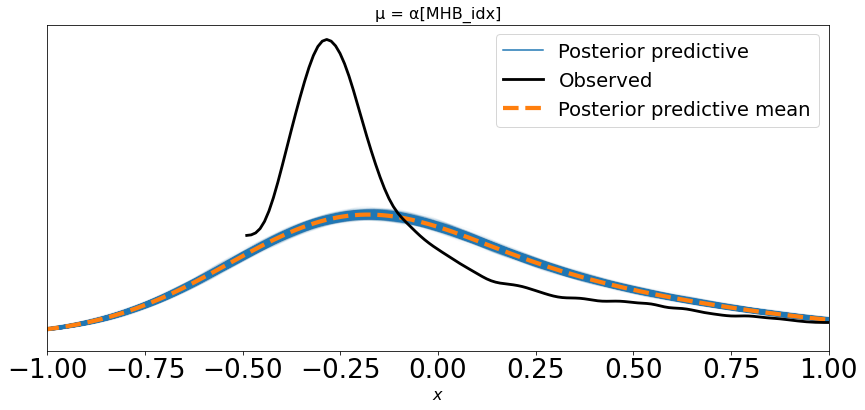

In [268]:
ppc_avg = pm.sample_posterior_predictive(trace=trace_avg, model=model_avg)
az.plot_ppc(ppc_avg, alpha=0.03, figsize=(14, 6)) #, backend="bokeh")
plt.xlim(-1, 1)
plt.title("μ = α[MHB_idx]", fontsize=16)
plt.xlabel('$x$', fontsize=16);

In [263]:
az.r2_score(np.array(wd.maxPg), ppc1.posterior_predictive.maxPg[0,:,:].values)  # μ = α[MHB_idx] + βw*wd.WaterGal + βs*wd.SandLB + βh*wd.LL

r2        0.600454
r2_std    0.002921
dtype: float64

In [271]:
az.r2_score(np.array(wd.maxPg), ppcH1.posterior_predictive.maxPg[0,:,:].values)   # μ = α[MHB_idx] + β[MHB_idx]*wd.LL

r2        0.626301
r2_std    0.002777
dtype: float64

In [196]:
az.r2_score(np.array(wd.maxPg), ppcH2.posterior_predictive.maxPg[0,:,:].values)   # μ = α[MHB_idx] + β[MHB_idx]*wd.WSLm*wd.LL

r2        0.400411
r2_std    0.002974
dtype: float64

In [269]:
az.r2_score(np.array(wd.maxPg), ppc_avg.posterior_predictive.maxPg[0,:,:].values)   # μ = α[MHB_idx]

r2        0.582776
r2_std    0.002884
dtype: float64

In [ ]:
with pm.Model() as modelHiro_v3:
# Priors
    #μ_α = pm.Normal('μ_α', mu=0, sigma=0.5)
    #σ_α = pm.Normal('σ_α', mu=0, sigma=0.5)
    #α = pm.Normal('α', mu=μ_α, sigma=0.5, shape=M_count)

    α = pm.Normal('α', mu=0, sigma=0.5, shape=M_count)
        
    β = pm.Normal('β', mu=0, sigma=0.5, shape=M_count)
    γ = pm.Normal('γ', mu=0, sigma=0.5, shape=Y_count)

    τ = pm.Normal('τ', mu=0, sigma=0.5, shape=Y_count)

# Model error
    ϵ = pm.Normal('ϵ', mu=0, sigma=0.5)

    μ = α[MHB_idx] + τ[YY_idx] + (γ[YY_idx] + β[MHB_idx]*wd.WSLm)*wd.LL
# Data likelihood
    maxPg = pm.Normal('maxPg', μ, ϵ, observed=wd.maxPg)

    traceHiro_v3 = pm.sample(2000, tune=1000, cores=2)

In [ ]:
YY_idx

In [ ]:


vi1_est = pd.Series(trace_vi1['α'].mean(axis=0), index=M_names)
vi1_se = pd.Series(trace_vi1['α'].std(axis=0), index=M_names)
order = vi1_est.sort_values(ascending=False).index

plt.figure(figsize=(10,8))

plt.scatter(range(len(vi1_est)), vi1_est[order])
for i, m, se in zip(range(len(vi1_est)), vi1_est[order], vi1_se[order]):
    plt.plot([i,i], [m-se, m+se], 'b-', alpha = 0.3)
plt.xlim(-10,410); plt.ylim(-1000,6000)
plt.xticks(fontsize=14); plt.yticks(fontsize=14)
plt.ylabel('α estimate', fontsize=16); plt.xlabel('Ordered Block', fontsize=16);

In [ ]:
# Varying Intercept Model, version ug
with pm.Model() as model_vi3:
    # Priors
    μ_α = pm.Normal('μ_α', mu=2125, sd=100)
    σ_α = pm.Normal('σ_α', mu=1725, sd=125)
    # Random intercepts
    α = pm.Gamma('α', mu=μ_α, sd=σ_α, shape=M_count)
    # Common slope
    βw = pm.Normal('βw', mu=18, sd=10)
    βs = pm.Normal('βs', mu=-0.25, sd=2)
    βh = pm.Normal('βh', mu=75, sd=25)
    
    # Model error
    ϵ = pm.Normal('ϵ', mu=1090,  sd=25)

    μ = μ = α[MHB_idx] + βw*wd.H2O_C + βs*wd.SAND_C + βh*wd.LL_C
    # Data likelihood
    maxPg = pm.Normal('maxPg', mu=μ, sd=ϵ, observed=wd.maxPg)
    
    trace_vi3 = pm.sample(2000, tune=1000, target_accept=0.90, cores=2)

In [ ]:
pm.plot_posterior(trace_vi3, var_names=['μ_α', 'σ_α', 'βw', 'βs', 'βh', 'ϵ'],
                  figsize=(12,12), textsize=12);

In [ ]:
pm.traceplot(trace_vi3, compact=True, combined=True)
pm.summary(trace_vi3).round(2)

In [ ]:
ppc3 = pm.sample_posterior_predictive(trace_vi3, 4000, model_vi3)
rcParams['figure.figsize'] = 14,6
ax = pm.kdeplot(data['maxPg'], plot_kwargs={'color': 'blue'}, bw=3, rug=True)
az.plot_kde(ppc3['maxPg'], plot_kwargs={'color': 'red'}, ax=ax, bw=2)
plt.xlim(-200, 18000)
plt.title("Normal/Gamma/Normal Distribution HORIZONTAL WELLS", fontsize=16)
plt.xlabel('$x$', fontsize=16);

In [ ]:
az.r2_score(np.array(data.maxPg), ppc3['maxPg'])

In [ ]:
vi3_est = pd.Series(trace_vi3['α'].mean(axis=0), index=M_names)
vi3_se = pd.Series(trace_vi3['α'].std(axis=0), index=M_names)
order = vi3_est.sort_values(ascending=False).index

plt.figure(figsize=(10,8))
plt.scatter(range(len(vi3_est)), vi3_est[order])
for i, m, se in zip(range(len(vi3_est)), vi3_est[order], vi3_se[order]):
    plt.plot([i,i], [m-se, m+se], 'b-', alpha = 0.3)
plt.xlim(-10,410); plt.ylim(0,7000)
plt.xticks(fontsize=14); plt.yticks(fontsize=14)
plt.ylabel('alpha estimate', fontsize=16); plt.xlabel('Ordered Block', fontsize=16);

Multi-level Model Modifications

In [ ]:
maxPg_avg = pm.sample_posterior_predictive_w([trace_vi1, trace_vi3], samples=1000,
                                        models=[model_vi1, model_vi3])

In [ ]:
rcParams['figure.figsize'] = 14,6
ax = pm.kdeplot(data['maxPg'], plot_kwargs={'color': 'blue'}, bw=2, rug=True)
az.plot_kde(maxPg_avg['maxPg'], plot_kwargs={'color': 'red'}, ax=ax, bw=2)
plt.xlim(-200, 18000)
plt.title("Average Distribution Likelihood HORIZONTAL WELLS", fontsize=16)
plt.xlabel('$x$', fontsize=16);

In [ ]:
az.r2_score(np.array(data.maxPg), maxPg_avg['maxPg'])

In [ ]:
_, ax = plt.subplots(figsize=(14,7))
az.plot_kde(data['maxPg'], plot_kwargs={'color': 'b'}, label='kde maxPo', bw=5)
az.plot_kde(ppc1['maxPg'], plot_kwargs={'color': 'C1'}, label='N_N_N', ax=ax)
az.plot_kde(ppc3['maxPg'], plot_kwargs={'color': 'C2'}, label='N_G_N', ax=ax)
#az.plot_kde(ppc5['maxPg'], plot_kwargs={'color': 'C3'}, label='TN_N_N', ax=ax)
az.plot_kde(maxPg_avg['maxPg'], plot_kwargs={'color': 'C4'}, label='weighted model', ax=ax)
plt.xlim(-200, 18000)
plt.plot(data['maxPg'], np.zeros_like(data['maxPg']), '|', label='observed data')
#plt.yticks([])
plt.ylim(-0.0001, 0.003)
plt.legend();

In [ ]:
cmp_df = az.compare({'model_ls':trace_ls, 'model_vi1':trace_vi1, 'model_vi3':trace_vi3},
                    method='BB-pseudo-BMA')
cmp_df

In [ ]:
az.plot_compare(cmp_df, figsize=(8,6));

Output Coding

In [ ]:
modA = data[['maxPg', 'maxPo', 'LL_C', 'H2O_C', 'SAND_C', 'MHB', 'API15']].groupby(['MHB']).mean()
modA.drop('API15', axis=1, inplace=True)
modA2 = data[['MHB','API15']].groupby(['MHB']).count()
modA2.columns = ['wellCnt']
modA = modA.sort_values(by=['maxPg'], ascending=False)
modA = modA2.join(modA ,how = 'left').sort_values(by=['maxPg'], ascending=False)

In [ ]:
vi1_est = pd.Series(trace_vi1['α'].mean(axis=0), index=M_names.MHB)
dfM1 = pd.DataFrame(vi1_est)
dfM1.columns = ['am1']
modA1 = dfM1.join(modA ,how = 'left').sort_values(by=['maxPg'], ascending=False)

dfM2 = pd.DataFrame(pd.Series(trace_vi3['α'].mean(axis=0), index=M_names.MHB))
dfM2.columns = ['am3']
modA2 = dfM2.join(modA1 ,how = 'left').sort_values(by=['maxPg'], ascending=False)



modA2['a0']=modA2['maxPg']
modA2['a1']=modA2['am1']
modA2['a3']=modA2['am3']


def mnormalize(df, ncols):
    df = df.copy()
    for i in ncols:
        if df[i].min() < 0:
            df[i] = (df[i] - df[i].min())
            df[i] = (df[i]/df[i].max())
        else: 
            df[i] = (df[i]/df[i].max())
    return df

ncols = ['a0','a1','a3']
modA2.sort_index(inplace=True)
nmodA2 = mnormalize(modA2, ncols)
nmodA2.head()

In [ ]:
vi1var= pm.backends.tracetab.trace_to_dataframe(trace_vi1, varnames=['βw', 'βs', 'βh'])
vi3var= pm.backends.tracetab.trace_to_dataframe(trace_vi3, varnames=['βw', 'βs', 'βh'])
#vi5var= pm.backends.tracetab.trace_to_dataframe(trace_vi5, varnames=['βw', 'βs', 'βh'])
mVar = pd.DataFrame()
mVar['m1'] = vi1var.mean()
mVar['m3'] = vi3var.mean()
#mVar['m5'] = vi5var.mean()

mVar

In [ ]:
nmodA2['m1Pg'] = nmodA2['am1'] + nmodA2[['H2O_C','SAND_C','LL_C']].mul(mVar['m1'].values, axis = 1).sum(axis=1)
nmodA2['m3Pg'] = nmodA2['am3'] + nmodA2[['H2O_C','SAND_C','LL_C']].mul(mVar['m3'].values, axis = 1).sum(axis=1)

nmodA2.head(15)